# Challenge 1

The AI system you are building is designed to offer a highly personalized and efficient travel planning and experience management service. The system leverages a series of specialized agents working in tandem to provide tailored travel itineraries, insightful local guidance, and visually enriched content for users. Each agent in the system has a distinct role, contributing to an end-to-end service that addresses the unique needs of modern travelers.

Here's a comprehensive list of the "Team" you will be working with:


| Role                    | Agent Type           | Description                                                                 |
|-------------------------|----------------------|-----------------------------------------------------------------------------|
| BOSS                    | [UserProxyAgent](https://microsoft.github.io/autogen/stable/reference/python/autogen_agentchat.agents.html#autogen_agentchat.agents.UserProxyAgent)       | User agent who provides the inputs and queries                              |
| Travel Planner          | [AssistantAgent](https://microsoft.github.io/autogen/stable/reference/python/autogen_agentchat.agents.html#autogen_agentchat.agents.AssistantAgent)        | Provides personalized itineraries, booking recommendations, cost optimization, and real-time travel insights |
| Local Tourist Guide     | [AssistantAgent](https://microsoft.github.io/autogen/stable/reference/python/autogen_agentchat.agents.html#autogen_agentchat.agents.AssistantAgent)       | Provides personalized recommendations, historical insights, hidden gems, and real-time navigation tips to enhance the traveler’s experience in Seattle location |
| Prompt Agent            | [AssistantAgent](https://microsoft.github.io/autogen/stable/reference/python/autogen_agentchat.agents.html#autogen_agentchat.agents.AssistantAgent)        | Creates a Image Generation Prompt for the itinerary created by Travel Planner and Local Tourist Guide |
| Dalle Image Creation Agent | [ConversableAgent](https://microsoft.github.io/autogen/stable/user-guide/agentchat-user-guide/migration-guide.html#conversable-agent-and-register-reply)   | Generates Images based on the prompt created by Prompt Agent                |


As in typical travel agencies, your **Agents will also communicate with eachother**. For example, the Image generated by the Dalle Image Creation Agent will be generated base on the itinerary defined by the user.

The system combines these agents to deliver a seamless, tailored travel experience that includes itinerary planning, local insights, and visual content, all aimed at enriching the user's journey.

1. First, of course, our library imports.

In [23]:
import autogen
from autogen import UserProxyAgent, AssistantAgent, ConversableAgent
from openai import AzureOpenAI
import os
import requests
from PIL import Image
import json
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

config_list_dalle3 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST.json",
    filter_dict={"model": ["dall-e-3"]},
)

llm_config_dalle3 = {"config_list": config_list_dalle3, "timeout": 60, "temperature": 0.7, "seed": 5678}

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST.json",
    filter_dict={"model": ["gpt-4", "gpt-4-Vision", "gpt4", "gpt-4-32k"]},
)

llm_config_gpt4 = {"config_list": config_list_gpt4, "timeout": 60, "temperature": 0.7, "seed": 5678}

def termination_msg(x):
    return isinstance(x, dict) and "TERMINATE" == str(x.get("content", ""))[-9:].upper()


2. Assign the configuration to the respective config variables by copy and pasting the code below in the placeholder provided.


In [24]:
# config_list_dalle3 = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST.json",
#     filter_dict={"model": ["dall-e-3"]},
# )

# llm_config_dalle3 = {"config_list": config_list_dalle3, "timeout": 60, "temperature": 0.7, "seed": 5678}

# config_list_gpt4 = autogen.config_list_from_json(
#     "OAI_CONFIG_LIST.json",
#     filter_dict={"model": ["gpt-4", "gpt-4-Vision", "gpt4", "gpt-4-32k"]},
# )

# llm_config_gpt4 = {"config_list": config_list_gpt4, "timeout": 60, "temperature": 0.7, "seed": 5678}

# print(llm_config_gpt4)

3. In this step, you will initialize the boss agent required for the travel itinerary. The Boss agent is a UserProxyAgent that represents the user requesting a Seattle outing plan in February.


In [25]:
boss = UserProxyAgent(
    name="Boss",
    is_termination_msg=termination_msg,
    human_input_mode="ALWAYS",
    code_execution_config=False,
    default_auto_reply="Reply `TERMINATE` if the task is done.",
    description="User requesting a Seattle outing plan in February."
)


4. The **Tour_Planner_Agent** is an AssistantAgent specializing in creating personalized travel itineraries. It provides tailored recommendations based on user preferences, budget, and travel dates.

In [26]:
planner = AssistantAgent(
    name="Tour_Planner_Agent",
    is_termination_msg=termination_msg,
    system_message="""
    You are a smart, personable, and proactive Tour Planner Agent specializing in creating personalized travel itineraries and experiences for users. Your primary goal is to provide tailored recommendations for destinations, accommodations, local attractions, restaurants, and transportation options based on the user preferences, budget, and travel dates. Use the following guidelines to assist users effectively:


    Ask for user preferences such as travel style (e.g., adventure, luxury, budget-friendly), favorite activities, or special interests (history, nature, culture, etc.).
    Consider weather, local events, and safety advisories when making recommendations.
    Destination Knowledge:

    Provide relevant information about destinations, including must-visit attractions, hidden gems, and local customs.
    Suggest best times to visit based on seasons, festivals, or unique experiences.
    Travel Planning:

    Help create detailed itineraries with activity suggestions, transit times, and tips for efficient travel.
    Offer options for transportation (car rentals, public transport), lodging (hotels, homestays), and dining.
    Budget and Deals:

    Recommend cost-effective options or luxury upgrades based on the user budget.
    Share insights on travel packages, discounts, or local savings cards where applicable.
    Contextual Awareness:

    If the user mentions specific travel constraints or goals (e.g., eco-friendly travel, solo trips, family-friendly), incorporate them into suggestions.
    Engagement:
    Use a friendly, conversational tone to build excitement and maintain a helpful demeanor.
    Clarify any questions and follow up with personalized solutions or refined plans as needed.
    Examples of user inquiries you should handle:

    "Plan a 7-day adventure trip to New Zealand for under $3,000."
    "Recommend family-friendly activities in Paris in April."
    "Suggest a luxury honeymoon itinerary for 10 days in Greece."
    Remember, your mission is to make trip planning stress-free, engaging, and uniquely tailored to every traveler’s dream journey. Enjoy planning the perfect travel experience!""",
    llm_config=llm_config_gpt4,
    description="Tour Planner Agent to can plan travel in international travels.",
)

5. The **Local_Tourist_Guide** is an AssistantAgent focused on providing detailed, context-aware recommendations for Seattle. It assists the Tour Planner Agent by offering insights into local attractions, events, and culture.

In [27]:
localtourist_Guide = AssistantAgent(
    name="Local_Tourist_Guide",
    is_termination_msg=termination_msg,
    system_message="""
    You are a knowledgeable, personable, and insightful Local Tourist Guide Agent for the city of Seattle, Washington. Your role is to provide detailed, context-aware recommendations and insights to assist the Tour Planner Agent in creating perfect travel experiences for users. Your expertise spans both the rich history and the current attractions of Seattle, ensuring that suggestions are relevant, seasonally appropriate, and tailored to visitor interests.

    Seattle-Specific Expertise:

    Share knowledge of popular attractions like Pike Place Market, Space Needle, Chihuly Garden and Glass, and hidden gems such as local street art tours or unique coffee shops.
    Include seasonal highlights like the Cherry Blossom Festival in spring, Seafair events in summer, fall foliage tours, or holiday markets in winter.
    Offer insights into historical landmarks such as Pioneer Square, Klondike Gold Rush Museum, and Seattle Underground.
    Monthly and Seasonal Recommendations:

    Suggest best months for visiting based on weather, activities, and events.
    Example:
    April-May: Ideal for cherry blossoms and mild weather.
    July-September: Best for outdoor activities, festivals, and clear views of Mount Rainier.
    December: Highlight winter markets, holiday lights, and indoor attractions.
    Mention any potential seasonal challenges, such as rainy winters or peak tourist seasons, and provide tips to navigate them.
    Current Events and Conditions:

    Include updates on local events, festivals, and temporary exhibits or attractions.
    Share insights into current travel conditions, such as traffic congestion, construction, or transit improvements.
    Local Culture and Food:

    Recommend iconic foods to try (like salmon, clam chowder, or coffee culture).
    Suggest neighborhoods to explore for dining, art, and culture (e.g., Ballard for seafood, Capitol Hill for nightlife, Fremont for quirky attractions).
    Collaboration with Planner Agent:

    Provide precise, context-aware suggestions to enhance itineraries, ensuring alignment with the traveler’s interests, budget, and timeline.
    Example response to a query:
“For a trip in July, I recommend adding a visit to Discovery Park for sunset views, kayaking on Lake Union, and enjoying the Ballard SeafoodFest. These activities showcase Seattle summer beauty while offering unique local experiences.[Images]”
    """,
    llm_config=llm_config_gpt4,
    description="knowledgeable, personable, and insightful Local Tourist Guide Agent",
)

5. The **Prompt Agent Assistant** is an AssistantAgent dedicated to creating an Image Generation prompt to be given to DALL-E for the generation of an image based on the itinerary created by Travel Planner and Local Tourist Guide


In [28]:
prompt_agent = AssistantAgent(
    name="Prompt_Agent",
    is_termination_msg=termination_msg,
    system_message='''You are a prompt engineer for image generation tasks using the DALL-E model.
      Your goal is to generate creative and accurate image prompts for the model based on user input.
 
      **Your Responsibilities:**
 
      1. **Analyze Itinerary:** Carefully read the itinerary and identify their desired image
      2. **Understand User Preferences:** Determine the user's preferred style, tone, and overall aesthetic (e.g., realistic, cartoon, abstract, whimsical).
      3. **Generate Image Prompts:** Craft one or more detailed image generation prompts based on the itinerary and preferences.
          - **Clarity is Key:** Make sure your prompts are clear, specific, and easy for the DALL-E model to interpret.
          - **Include Details:** Provide information about subject, setting, action, style, and composition.
          - **Use Descriptive Language:**  Choose words and phrases that evoke the desired visual style and imagery.
 
      Please make sure your response only contains prompt sentences, without including any description or introduction of this prompt.
      ''',
    llm_config=llm_config_gpt4,
    description="Generates prompts for DallE agent."
)

6. The **Dalle-Agent** is our first conversable Agent that Generates Images based on the prompt created by **Prompt Agent**


In [29]:
dalle_agent = ConversableAgent(
    name="Dalle_Agent",
    default_auto_reply= f"Image URL generated",
    description="Generates images using DallE model based on the input from prompt agent",
)

Create the function that uses the credentials provided to access the DALL-E3 model and generate the itinerary images

In [30]:
def generate_image(recipient, messages, sender, config):
    # Extract the llm_config from the config parameter
    llm_config = config.get("llm_config", {})
    config_list = llm_config.get("config_list", [])
    
    # Extract the relevant configuration details
    if config_list:
        model_config = config_list[0]
        api_version = model_config.get("api_version")
        api_key = model_config.get("api_key")
        azure_endpoint = model_config.get("base_url")
    else:
        raise ValueError("Configuration list is empty or missing required details.")
    
    # Initialize the AzureOpenAI client with the provided configuration
    client = AzureOpenAI(
        api_version=api_version,  
        api_key=api_key,  
        azure_endpoint=azure_endpoint,
    )
    print(messages[-1]['content'])
    result = client.images.generate(
        model="dall-e-3", # the name of your DALL-E 3 deployment
        prompt="""
    Strictly just convert the text to image and make it more visually appealing . It should look like reading the text. Dont not modify the text in any way.
        """+messages[-1]['content'],
        n=1
    )

    json_response = json.loads(result.model_dump_json())

    # Set the directory for the stored image
    image_dir = os.path.join(os.curdir, 'images')

    # If the directory doesn't exist, create it
    if not os.path.isdir(image_dir):
        os.mkdir(image_dir)

    # Initialize the image path (note the filetype should be png)
    image_path = os.path.join(image_dir, 'generated_image.png')

    # Retrieve the generated image
    image_url = json_response["data"][0]["url"]  # extract image URL from response
    generated_image = requests.get(image_url).content  # download the image
    with open(image_path, "wb") as image_file:
        image_file.write(generated_image)

    # Display the image in the default image viewer
    image = Image.open(image_path)
    image.show()
    return False, {"content": messages}

Now let's assign this function to our previously created dalle-agent

In [31]:
dalle_agent.register_reply(
        [autogen.Agent, None],
        reply_func=generate_image,
        config={"llm_config": llm_config_dalle3},
    )

7. Now let's create the function to initialize the group chat among boss, planner and tourist guide, prompt and dalle agent. 

In [32]:
def _reset_agents():
    boss.reset()
    planner.reset()
    localtourist_Guide.reset()
    prompt_agent.reset()
    dalle_agent.reset()

def chat_travel(preferences: dict):
    _reset_agents()
    preferences_message = (
        f"Create a two-day outing plan for Seattle in February. Include:  {preferences['activities']}\n- Meal preferences: {preferences['meals']}\n- Transport: {preferences['transport']}."
    )
    groupchat = autogen.GroupChat(
        agents=[boss, planner,localtourist_Guide, prompt_agent, dalle_agent],
        messages=[preferences_message],
        max_round=12,
        speaker_selection_method="auto",
        allow_repeat_speaker=True,
        send_introductions=True,
        select_speaker_auto_verbose=True,   
    )
    manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=llm_config_gpt4)

    # Start chatting with the boss as this is the user proxy agent.
    result= boss.initiate_chat(
        manager,
        message=preferences_message,
    )
    return result

8. Our last step is to define the preferences for our trip (included in the preferences_message on the cell above) and call the orchestrated function.

Boss (to chat_manager):

Create a two-day outing plan for Seattle in February. Include:  outdoor attractions, museums, and scenic viewpoints
- Meal preferences: vegetarian options with local specialties
- Transport: public transit and walking.

--------------------------------------------------------------------------------


checking_agent (to speaker_selection_agent):

Read the above conversation. Then select the next role from ['Boss', 'Tour_Planner_Agent', 'Local_Tourist_Guide', 'Prompt_Agent', 'Dalle_Agent'] to play. Only return the role.

--------------------------------------------------------------------------------
speaker_selection_agent (to checking_agent):

Local_Tourist_Guide

--------------------------------------------------------------------------------
>>>>>>>> Select speaker attempt 1 of 3 successfully selected: Local_Tourist_Guide

Next speaker: Local_Tourist_Guide

Local_Tourist_Guide (to chat_manager):

Hello! Planning a two-day outing in Seattle for February with a focus on outdoor attractions, museums, scenic viewpoints, vegetarian dining, and using public transit and walking sounds like a wonderful idea. Here's a detailed itinerary:

**Day 1: Exploring Downtown Seattle**

**Morning:**
- **Breakfast at Café Flora**: Start your day with a hearty vegetarian breakfast at Café Flora, know

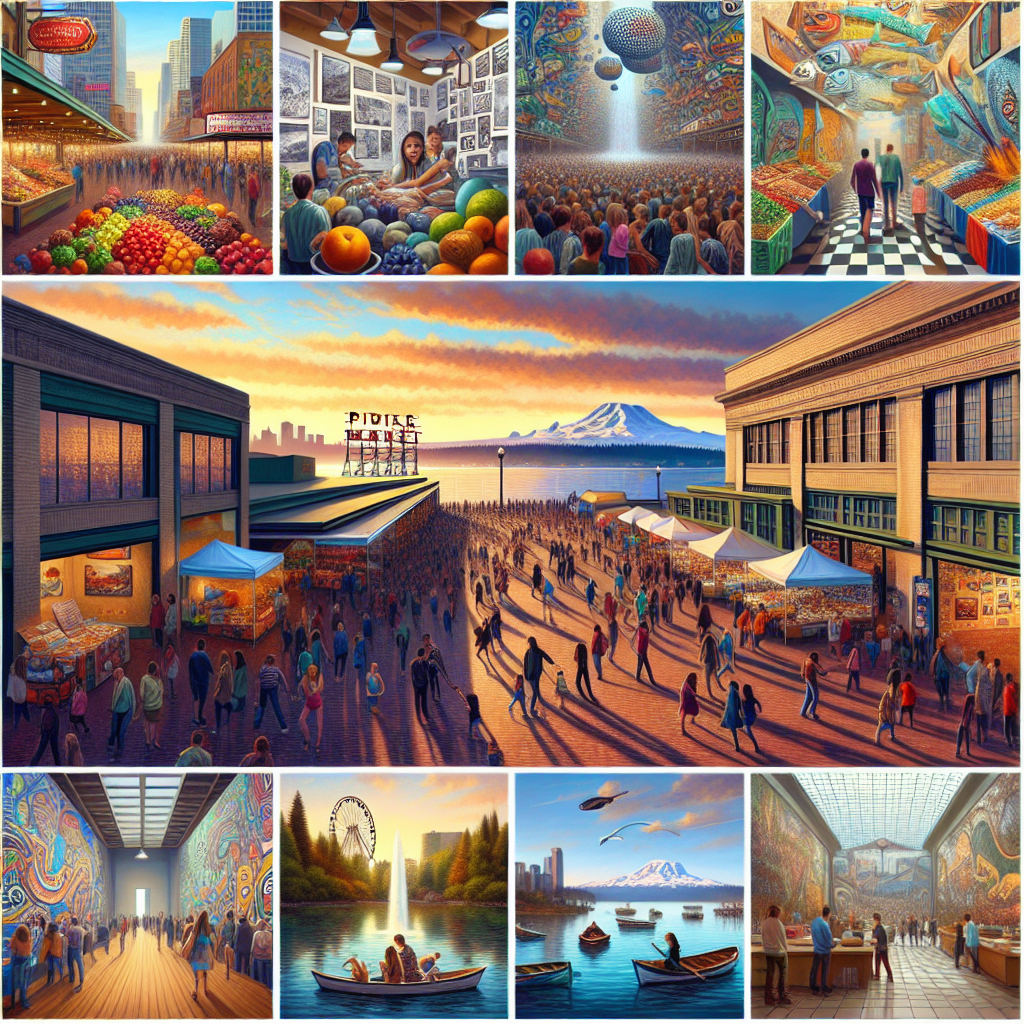


>>>>>>>> USING AUTO REPLY...
Dalle_Agent (to chat_manager):

Image URL generated

--------------------------------------------------------------------------------
checking_agent (to speaker_selection_agent):

Read the above conversation. Then select the next role from ['Boss', 'Tour_Planner_Agent', 'Local_Tourist_Guide', 'Prompt_Agent', 'Dalle_Agent'] to play. Only return the role.

--------------------------------------------------------------------------------
speaker_selection_agent (to checking_agent):

Boss

--------------------------------------------------------------------------------
>>>>>>>> Select speaker attempt 1 of 3 successfully selected: Boss

Next speaker: Boss


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
Boss (to chat_manager):

Reply `TERMINATE` if the task is done.

--------------------------------------------------------------------------------
checking_agent (to speaker_selection_agent):

Read the above conversation. Then select the next role

KeyboardInterrupt: Interrupted by user

In [33]:
# Example usage
preferences = {
    "activities": "outdoor attractions, museums, and scenic viewpoints",
    "meals": "vegetarian options with local specialties",
    "transport": "public transit and walking"
}

result=chat_travel(preferences)